# Self interest transactions

This content is part of the following scientific paper: https://people.mpi-sws.org/~johnme/pdf/messias_imc2021_btc_tx_ordering.pdf
```
Selfish & Opaque Transaction Ordering in the Bitcoin Blockchain: The Case for Chain Neutrality
Johnnatan Messias, Mohamed Alzayat, Balakrishnan Chandrasekaran, Krishna P. Gummadi, Patrick Loiseau, and Alan Mislove.
In Proceedings of the ACM SIGCOMM Internet Measurement Conference (IMC 2021). Virtual Event. November, 2021.
```

## Import useful functions

In [1]:
from utils_plot import *
import pandas as pd
from tqdm.notebook import tqdm
import gzip
from ast import literal_eval
import numpy as np
from scipy.stats import binom
import itertools
pd.set_option('max_colwidth', 10000)

In [2]:
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

In [3]:
tqdm.pandas()

In [4]:
# from common import *

In [5]:
percentiles = [.01, .05, .1, .2, .25, .50, .75, .8, .9, .95, .99]

In [6]:
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor

In [7]:
def load_transactions(n_cores=5):
    dfs = list()
    filenames = ['data-2020/transactions/' + filename for filename in os.listdir('data-2020/transactions/') if filename.endswith('.csv.gz')]
    with ProcessPoolExecutor(n_cores) as p:
        dfs = list(tqdm(p.map(load_transaction, filenames), desc='Loading files', total=len(filenames)))
    print('Concating dataframes')
    return pd.concat(dfs)

def load_transaction(filename):
    df = read_file(filename)
    df['spends_from'] = df['spends_from'].apply(literal_eval)
    df['vin_addresses'] = df['vin_addresses'].apply(literal_eval)
    df['vout_addresses'] = df['vout_addresses'].apply(literal_eval)
    df['time'] = pd.to_datetime(df['time'])
    df['n_utxo'] = df['n_vout'] - df['n_vin']
    # df['tx_position_percentile'] = (df['tx_position']/df['n_tx']).mul(100).astype(int)
    return df

def read_file(filename, usecols=None, parse_dates=False):
    return pd.read_csv(filename, sep=';', compression='gzip', usecols=usecols, parse_dates=parse_dates)

In [8]:
def get_miners_wallets_from_blocks(df):
    mpo_addresses = dict()
    for index, row in df[['miner', 'addresses']].iterrows():
        if not row['miner'] in mpo_addresses:
            mpo_addresses[row['miner']] = list()
        mpo_addresses[row['miner']] += [address for address in row['addresses']]
    for miner in mpo_addresses:
        mpo_addresses[miner] = list(set(mpo_addresses[miner]))
    return mpo_addresses

## Loading the data set

### Miners

In [9]:
miners_df = read_file('data-2020/miners-610691--663904.csv.gz')
miners_df['addresses'] = miners_df['addresses'].progress_apply(lambda x: x.split(','))
miners_df['n_addresses'] = miners_df['addresses'].progress_apply(len)
miners_df.shape

  0%|          | 0/53214 [00:00<?, ?it/s]

  0%|          | 0/53214 [00:00<?, ?it/s]

(53214, 5)

In [10]:
miners_df.columns

Index(['block_height', 'miner', 'n_tx', 'addresses', 'n_addresses'], dtype='object')

In [11]:
miners_df.head()

,block_height,miner,n_tx,addresses,n_addresses
0,610691,Poolin,2500,[['1KDf847BWEMwthPHFtvWAfESdQMRnr25f7']],1
1,610692,Huobi,1840,[['1C81BGyi8SJ919UxnHm2iwNmaN2RHfU4us']],1
2,610693,F2Pool,1105,[['1KFHE7w8BhaENAswwryaoccDb6qcT6DbYY']],1
3,610694,Unknown,982,[['3QLeXx1J9Tp3TBnQyHrhVxne9KqkAS9JSR']],1
4,610695,AntPool,2881,[['12dRugNcdxK39288NjcDV4GX7rMsKCGn6B']],1


In [12]:
top_miners = miners_df.miner.value_counts().index

### Blocks

In [13]:
blocks_df = read_file('data-2020/blocks-610691--663904.csv.gz')
blocks_df['time'] = pd.to_datetime(blocks_df['time'])
blocks_df['mediantime'] = pd.to_datetime(blocks_df['mediantime'])
blocks_df.shape

(53214, 18)

In [14]:
blocks_df.columns

Index(['height', 'hash', 'nTx', 'bits', 'size', 'strippedsize', 'weight',
       'vsize', 'time', 'mediantime', 'nonce', 'version', 'chainwork',
       'difficulty', 'merkleroot', 'versionHex', 'nextblockhash',
       'previousblockhash'],
      dtype='object')

In [15]:
blocks_df.head()

,height,hash,nTx,bits,size,strippedsize,weight,vsize,time,mediantime,nonce,version,chainwork,difficulty,merkleroot,versionHex,nextblockhash,previousblockhash
0,610691,00000000000000000001cc49c6ebb2e7546615e1f168161c75d1843257cb233a,2500,1715bcd0,1250129,914500,3993629,998407.25,2020-01-01 00:03:05,2019-12-31 23:07:30,240614342,549453824,00000000000000000000000000000000000000000b517c9e0b7913153c583488,1.29485934e+13,6616c395c80cd1b01704d6a4eb83a96d94c1ee02736c7bff1617abc77c631f89,20c00000,000000000000000000117f1821db8f36e05a70ed9dbffa5ebb0857021f0f2f51,00000000000000000005f0cc9b565336243d08e65f71ba179a33921fb33aeb93
1,610692,000000000000000000117f1821db8f36e05a70ed9dbffa5ebb0857021f0f2f51,1840,1715bcd0,661706,424345,1934741,483685.25,2020-01-01 00:07:32,2019-12-31 23:13:16,2264085561,536870912,00000000000000000000000000000000000000000b518864eb8f9dbe277d9bda,1.29485934e+13,973352f46a24d90c3f6a8e897edf956b1a2924f2c9d126a39b0895cb245a9d23,20000000,00000000000000000014a2d6530192263dffbb1723acc9d5734d9514138a3f0c,00000000000000000001cc49c6ebb2e7546615e1f168161c75d1843257cb233a
2,610693,00000000000000000014a2d6530192263dffbb1723acc9d5734d9514138a3f0c,1105,1715bcd0,436344,284543,1289973,322493.25,2020-01-01 00:13:34,2019-12-31 23:22:50,4185504105,1073733632,00000000000000000000000000000000000000000b51942bcba6286712a3032c,1.29485934e+13,f7f2ae580b932bea05e76f9d89b510bfeb5942e499d9cabe3beb9c9fa8f3fa9c,3fffe000,000000000000000000053ba498a77d2e186a0d530abe5cfc44aad1afe3ad867f,000000000000000000117f1821db8f36e05a70ed9dbffa5ebb0857021f0f2f51
3,610694,000000000000000000053ba498a77d2e186a0d530abe5cfc44aad1afe3ad867f,982,1715bcd0,467181,285676,1324209,331052.25,2020-01-01 00:19:00,2019-12-31 23:37:18,4102308397,1073733632,00000000000000000000000000000000000000000b519ff2abbcb30ffdc86a7e,1.29485934e+13,0fb984cd84240b3c1631e9a6ef7e69def28349a6c0fe0657954231a17104df93,3fffe000,00000000000000000009ae968a937bea55223270e64058a2fea352d73a57fc22,00000000000000000014a2d6530192263dffbb1723acc9d5734d9514138a3f0c
4,610695,00000000000000000009ae968a937bea55223270e64058a2fea352d73a57fc22,2881,1715bcd0,1123752,758667,3399753,849938.25,2020-01-01 00:37:32,2019-12-31 23:41:32,3452559148,545259520,00000000000000000000000000000000000000000b51abb98bd33db8e8edd1d0,1.29485934e+13,c1a7f17dc14bd5191ff75864a3f3242583e0cf642078c0abde6ac8be682d9ec1,20800000,00000000000000000003510b551473f79a7543cfad1ce97a4ad0793882f6442c,000000000000000000053ba498a77d2e186a0d530abe5cfc44aad1afe3ad867f


### Transactions

In [16]:
txs_df = load_transactions(n_cores=cpu_count()-1)
txs_df.shape

Loading files:   0%|          | 0/107 [00:00<?, ?it/s]

Concating dataframes


(112542268, 28)

In [17]:
txs_df.sort_values(by=['block_height', 'tx_position'], inplace=True)

In [18]:
print("set index as time")
txs_df.set_index('time', inplace=True)

set index as time


In [19]:
txs_df.columns

Index(['block_height', 'miner', 'txid', 'is_cpfp', 'is_coinbase',
       'tx_position', 'vin', 'vout', 'n_vin', 'n_vout', 'hash', 'vsize',
       'size', 'fee', 'cfeerate', 'satsize', 'feerate', 'version', 'locktime',
       'n_addresses', 'n_spends_from', 'spends_from', 'n_vin_addresses',
       'n_vout_addresses', 'vin_addresses', 'vout_addresses', 'n_utxo'],
      dtype='object')

In [20]:
txs_df.head()[['txid', 'n_addresses', 'n_addresses', 'fee', 'vsize', 'feerate', 'satsize', 'cfeerate']]

,txid,n_addresses,n_addresses,fee,vsize,feerate,satsize,cfeerate
time,,,,,,,,
2020-01-01 00:03:05,e12aadca7a51e816dd804536f6eb140bbf959ce7697626cb9c2a88d33ace5b1f,1,1,-12.67534026,335,-37.83683660,-3.78368366e+06,-3783683659
2020-01-01 00:03:05,c425c221200841914c7189d22f21d84616a7809a6aa7a4308a4eab27ae957cbc,2,2,0.00226773,223,0.01016919,1.01691928e+03,1016919
2020-01-01 00:03:05,630a2610828f40c370ce896bb3ba59561e7b0c1abc99452da72d7d896b3d372b,1,1,0.00170170,381,0.00446640,4.46640420e+02,446640
2020-01-01 00:03:05,748b26c5570a8c95250817f1a77ba5075769f5e16adb25af92025fe0284abc3e,1,1,0.00170170,381,0.00446640,4.46640420e+02,446640
2020-01-01 00:03:05,d126a038ca44a48ce79cc2a67318bf1be5e09b8d9e781d53533d64c0cb125d82,1,1,0.00170170,381,0.00446640,4.46640420e+02,446640


In [21]:
txs_df.head()

,block_height,miner,txid,is_cpfp,is_coinbase,tx_position,vin,vout,n_vin,n_vout,...,version,locktime,n_addresses,n_spends_from,spends_from,n_vin_addresses,n_vout_addresses,vin_addresses,vout_addresses,n_utxo
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:03:05,610691,Poolin,e12aadca7a51e816dd804536f6eb140bbf959ce7697626cb9c2a88d33ace5b1f,False,True,0,0.00000000,12.67534026,1,4,...,1,2131434439,1,0,[],0,1,[],"[(1KDf847BWEMwthPHFtvWAfESdQMRnr25f7, 12.67534026)]",3
2020-01-01 00:03:05,610691,Poolin,c425c221200841914c7189d22f21d84616a7809a6aa7a4308a4eab27ae957cbc,False,False,1,1.31800000,1.31573227,1,2,...,1,0,2,1,[ce6435836733787db9f7cc8fd14f5f351c0414d66985f5a2946ca4cecc920ac6],1,2,"[(17z8pewch1CbQvg75uqKP4eo5YQwLapccC, 1.318)]","[(35LN5maPgWjhrKnYcMnwQD5oAoRcdTwNga, 0.5), (1EvL2QhZT9PHvsGaVer9LVkjWrExaGfxpK, 0.81573227)]",1
2020-01-01 00:03:05,610691,Poolin,630a2610828f40c370ce896bb3ba59561e7b0c1abc99452da72d7d896b3d372b,False,False,2,0.00331581,0.00161411,2,2,...,1,0,1,2,"[6f3698c19147cb6fa69a088608b45c29d31009e9f36549b06f21ad5b7903ad38, 9b52b5120a0ef9605f0eec4b4a6b5114cb08c3f6877c63286fc064f409e7a8b8]",2,1,"[(1FGiZB7K757EUixGcyeyME6Jp8qQZEiUUk, 0.00142631), (1FGiZB7K757EUixGcyeyME6Jp8qQZEiUUk, 0.0018895)]","[(1FGiZB7K757EUixGcyeyME6Jp8qQZEiUUk, 0.00161411)]",0
2020-01-01 00:03:05,610691,Poolin,748b26c5570a8c95250817f1a77ba5075769f5e16adb25af92025fe0284abc3e,False,False,3,0.00477006,0.00306836,2,2,...,1,0,1,2,"[77c68719c3be4691438a8325821dffe7911171180f1c8f01dd0438e00dd3caf8, 22ad0ae68de93eb1218ae597bdcab9f4495ca6a072cb7e11eb31f948a9e7140b]",2,1,"[(1JctmVUHHfchRQHR1K1v9E9rs3mSWLGEmt, 0.00231716), (1JctmVUHHfchRQHR1K1v9E9rs3mSWLGEmt, 0.0024529)]","[(1JctmVUHHfchRQHR1K1v9E9rs3mSWLGEmt, 0.00306836)]",0
2020-01-01 00:03:05,610691,Poolin,d126a038ca44a48ce79cc2a67318bf1be5e09b8d9e781d53533d64c0cb125d82,False,False,4,0.00463432,0.00293262,2,2,...,1,0,1,2,"[ec0c923602107f4395fe01051d86febbd1904acc1b9d220020005e98874d5a96, 69851387f4921f4569de06197819db188bc5ed91085cb322f903116785790f4c]",2,1,"[(12tLxUuMAnvh9pXdBSBwxL5VtK68dTbNS3, 0.00231716), (12tLxUuMAnvh9pXdBSBwxL5VtK68dTbNS3, 0.00231716)]","[(12tLxUuMAnvh9pXdBSBwxL5VtK68dTbNS3, 0.00293262)]",0


In [22]:
txs_df.is_coinbase.value_counts()

False    112489054
True         53214
Name: is_coinbase, dtype: int64

## Merging data sets

In [23]:
print('merging blocks to miners')
miners_df = miners_df.merge(
    blocks_df[['height', 'time', 'nTx']], left_on='block_height', right_on='height', how='left'
).drop(columns=['height', 'n_tx']).rename(columns={'nTx': 'n_tx'})

print('merging miners and blocks')
blocks_df = blocks_df.merge(
    miners_df[['block_height', 'miner']], left_on='height', right_on='block_height', how='left'
).drop(columns=['height'])

merging blocks to miners
merging miners and blocks


## Filtering miners and blocks to 2020 data set

In [24]:
miners_df.set_index('time', inplace=True)

In [25]:
miner_stats = pd.DataFrame([miners_df.miner.value_counts(normalize=False), miners_df.miner.value_counts(normalize=True)]).transpose()
miner_stats.columns = ['abs. number', 'fraction']
miner_stats

,abs. number,fraction
F2Pool,9326.0,0.17525463
Poolin,7876.0,0.14800616
BTC.com,6381.0,0.11991205
AntPool,5832.0,0.10959522
Huobi,3990.0,0.07498027
ViaBTC,3596.0,0.06757620
1THash & 58COIN,3252.0,0.06111174
Okex,2569.0,0.04827677
Binance Pool,2393.0,0.04496937
SlushPool,1994.0,0.03747134


# Building filtered data set with non-CPFP txs

In [26]:
# Filtering out CPFP-txs and coinbase transactions
non_cpfp_txs_df = txs_df.query('not is_coinbase and not is_cpfp')

In [27]:
non_cpfp_txs_df.shape

(90994433, 27)

In [28]:
txs_df.query('not is_coinbase').is_cpfp.value_counts()

False    90994433
True     21494621
Name: is_cpfp, dtype: int64

## Computing SPPE values

In [29]:
print('Computing tx_position_observed')
non_cpfp_txs_df.loc[:, 'tx_position_observed'] = (non_cpfp_txs_df.groupby("block_height")['tx_position'].rank(method='first', ascending=True).astype(int))

print('Computing tx_position_predicted')
non_cpfp_txs_df.loc[:, 'tx_position_predicted'] = (non_cpfp_txs_df.groupby("block_height")['cfeerate'].rank(method='first', ascending=False).astype(int))

print('Computing rank_percentile_observed')
non_cpfp_txs_df.loc[:, 'rank_percentile_observed'] = (non_cpfp_txs_df.groupby(
    "block_height"
)['tx_position_observed'].rank(method='average', ascending=True, pct=True).mul(100).round(0).astype(int))


print('Computing rank_percentile_predicted')
non_cpfp_txs_df.loc[:, 'rank_percentile_predicted'] = (non_cpfp_txs_df.groupby(
    "block_height"
)['tx_position_predicted'].rank(method='average', ascending=True, pct=True).mul(100).round(0).astype(int))

Computing tx_position_observed


/home/johnme/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Computing tx_position_predicted
Computing rank_percentile_observed
Computing rank_percentile_predicted


In [30]:
# Computing SPPE
non_cpfp_txs_df.loc[:, 'SPPE'] = (non_cpfp_txs_df['rank_percentile_predicted'] - non_cpfp_txs_df['rank_percentile_observed'])

In [31]:
# Computing PPE
non_cpfp_txs_df.loc[:, 'PPE'] = (non_cpfp_txs_df['rank_percentile_predicted'] - non_cpfp_txs_df['rank_percentile_observed']).abs()

In [32]:
non_cpfp_txs_df.columns

Index(['block_height', 'miner', 'txid', 'is_cpfp', 'is_coinbase',
       'tx_position', 'vin', 'vout', 'n_vin', 'n_vout', 'hash', 'vsize',
       'size', 'fee', 'cfeerate', 'satsize', 'feerate', 'version', 'locktime',
       'n_addresses', 'n_spends_from', 'spends_from', 'n_vin_addresses',
       'n_vout_addresses', 'vin_addresses', 'vout_addresses', 'n_utxo',
       'tx_position_observed', 'tx_position_predicted',
       'rank_percentile_observed', 'rank_percentile_predicted', 'SPPE', 'PPE'],
      dtype='object')

In [33]:
non_cpfp_txs_df.head(1)

,block_height,miner,txid,is_cpfp,is_coinbase,tx_position,vin,vout,n_vin,n_vout,...,n_vout_addresses,vin_addresses,vout_addresses,n_utxo,tx_position_observed,tx_position_predicted,rank_percentile_observed,rank_percentile_predicted,SPPE,PPE
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:03:05,610691,Poolin,c425c221200841914c7189d22f21d84616a7809a6aa7a4308a4eab27ae957cbc,False,False,1,1.318,1.31573227,1,2,...,2,"[(17z8pewch1CbQvg75uqKP4eo5YQwLapccC, 1.318)]","[(35LN5maPgWjhrKnYcMnwQD5oAoRcdTwNga, 0.5), (1EvL2QhZT9PHvsGaVer9LVkjWrExaGfxpK, 0.81573227)]",1,1,1,0,0,0,0


In [34]:
non_cpfp_txs_df.block_height.unique().size

52974

count    52974.00000000
mean         2.65025145
std          2.89348231
min          0.00000000
1%           0.00000000
5%           0.14972141
10%          0.31747445
20%          0.59906655
25%          0.76253307
50%          1.77970367
75%          3.47666003
80%          4.03104358
90%          5.95955267
95%          8.22438099
99%         13.79398372
max         40.64459016
Name: PPE, dtype: float64

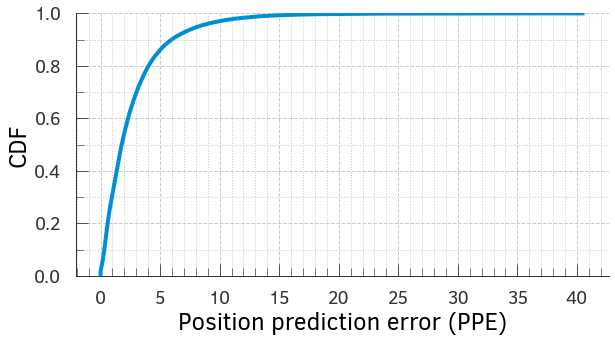

In [35]:
data = non_cpfp_txs_df[['block_height', 'PPE']].groupby('block_height').mean().PPE
ax = plot_cdf(data=data, x_label='Position prediction error (PPE)', y_label='CDF', log=False, interval=None,
             color=None, ax=None, label=None,
             linewidth=None, alpha=1, y_lim=[0, 1], marker=None, markersize=None)
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(.1))
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle=':')
data.describe(percentiles=percentiles)

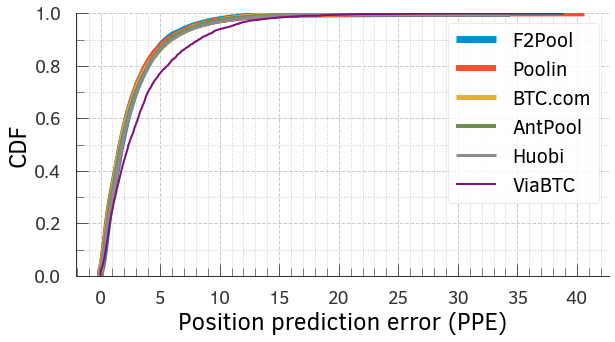

In [36]:
ax = None
linewidth = 7
style = ['solid', 'dotted', 'dashed', 'dashdot', 'solid', 'dotted']

for miner in top_miners[:6]:
    data = non_cpfp_txs_df.query('miner == @miner')[['block_height', 'PPE']].groupby('block_height').mean().PPE
    ax = plot_cdf(ax=ax, data=data, x_label='Position prediction error (PPE)', y_label='CDF', log=False, interval=None,
                 color=None, label=miner,
                 linewidth=linewidth, linestyle='-', alpha=1, 
                  y_lim=[0, 1], marker=None, markersize=None)
    linewidth-=1
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(.1))
ax.grid(b=True, which='major', linestyle='--')
ax.grid(b=True, which='minor', linestyle=':')
plt.legend()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

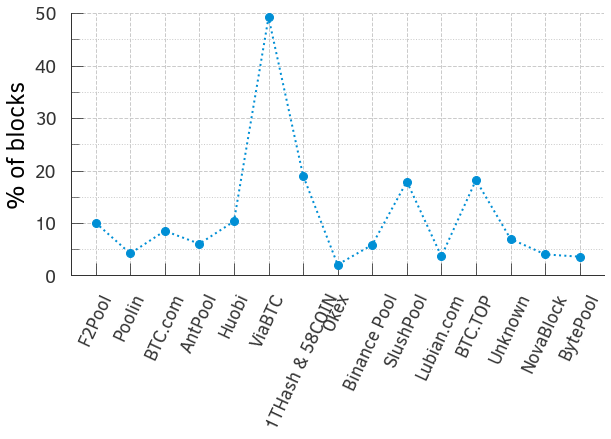

In [37]:
deviation_perc = 99
data = non_cpfp_txs_df.query(f"SPPE >= {deviation_perc}")
data = (100 * (data[['block_height', 'miner']].drop_duplicates().miner.value_counts(normalize=False)/miners_df.miner.value_counts(normalize=False))).round(2)
data = data.loc[top_miners[:15]]
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(data.index, data, linewidth=2, linestyle=':', marker='o', markersize=8)
ax.set_ylabel('% of blocks')
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.set_ylim((0, 50))
ax.grid(b=True, which='minor', linestyle=':')
plt.xticks(rotation=65, ha="center")

# Own MPO Wallet analysis

In [38]:
# Get MPOs wallet addresses
mpo_addresses_df = list()
for d in tqdm(get_miners_wallets_from_blocks(df=miners_df).items()):
    mpo_addresses_df += [{'miner': d[0], 'address': x} for x in d[1]]
mpo_addresses_df = pd.DataFrame(mpo_addresses_df)
mpo_addresses_df.shape

  0%|          | 0/31 [00:00<?, ?it/s]

(414, 2)

In [39]:
mpo_addresses_df.head()

,miner,address
0,Poolin,['1NH2b137CM62oJAacCST3VkQMf71E4aS33']
1,Poolin,['35RtBrgeMj5NKQZUg2mAanrHQmnbaedoDV']
2,Poolin,['13shcbJ4UfUiK97Mz3ZaU4VYUdHEJonPM3']
3,Poolin,['1KDf847BWEMwthPHFtvWAfESdQMRnr25f7']
4,Poolin,['1FPK9iRTEpvN3HU1a9DV8PmkWKmxW1KmEd']


In [40]:
mpo_addresses_df.query('miner != "Unknown"').shape

(366, 2)

In [41]:
mpo_addresses_df.drop_duplicates().shape

(414, 2)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'F2Pool'),
  Text(1, 0, 'Poolin'),
  Text(2, 0, 'BTC.com'),
  Text(3, 0, 'AntPool'),
  Text(4, 0, 'Huobi'),
  Text(5, 0, 'ViaBTC'),
  Text(6, 0, '1THash & 58COIN'),
  Text(7, 0, 'Okex'),
  Text(8, 0, 'Binance Pool'),
  Text(9, 0, 'SlushPool'),
  Text(10, 0, 'Lubian.com'),
  Text(11, 0, 'BTC.TOP'),
  Text(12, 0, 'NovaBlock'),
  Text(13, 0, 'BytePool'),
  Text(14, 0, 'SpiderPool'),
  Text(15, 0, 'BitFury'),
  Text(16, 0, 'E2M & BTC.TOP'),
  Text(17, 0, 'BitDeer'),
  Text(18, 0, 'Buffett'),
  Text(19, 0, 'Bitcoin.com')])

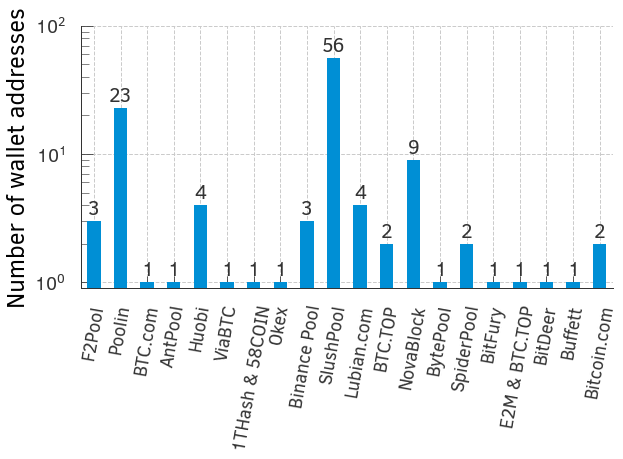

In [42]:
data = mpo_addresses_df.query('miner != "Unknown"')
top_miners_ = [miner for miner in top_miners if miner != 'Unknown']
ax = data.miner.value_counts(normalize=False).loc[top_miners_[:20]].plot.bar()
autolabel(ax.patches, precision=0)
ax.set_ylabel('Number of wallet addresses')
ax.set_yscale('log')
ax.set_ylim((0.9, 100))
plt.xticks(rotation=80)

In [43]:
mpo_addresses_df.query('miner == "BitDeer"')

,miner,address
407,BitDeer,['bc1qjl8uwezzlech723lpnyuza0h2cdkvxvh54v3dn']


In [44]:
mpo_addresses_df.query('miner == "Buffett"')

,miner,address
398,Buffett,['34Jpa4Eu3ApoPVUKNTN2WeuXVVq1jzxgPi']


In [45]:
mpo_addresses = set(mpo_addresses_df.query('miner != "Unknown"').address.unique().tolist())
len(mpo_addresses)

363

In [46]:
def get_matrix_addresses(mpo_addresses_df, addresses, miners):
    matrix_dict = dict()
    for miner_a in miners:
        matrix_dict[miner_a] = {}
        for miner_b in miners:
            matrix_dict[miner_a][miner_b] = 0
    for address in tqdm(addresses):
        pairs_ = itertools.combinations(mpo_addresses_df.query('address == @address').miner, 2)
        for pair_ in pairs_:
            matrix_dict[pair_[0]][pair_[1]] += 1
            matrix_dict[pair_[1]][pair_[0]] += 1
    return pd.DataFrame(matrix_dict)

In [47]:
addresses = mpo_addresses_df.address.unique()
miners = miners_df.miner.unique()
matrix_df = get_matrix_addresses(mpo_addresses_df, addresses, miners)

  0%|          | 0/402 [00:00<?, ?it/s]

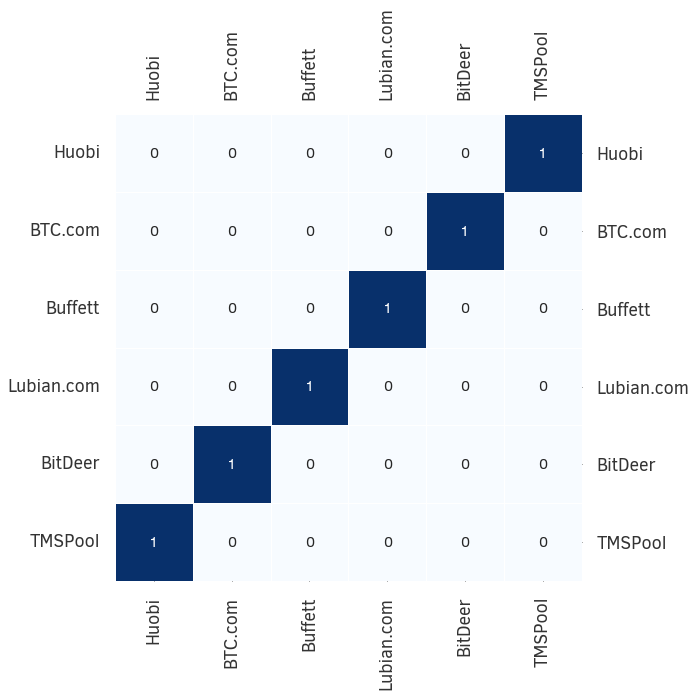

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(matrix_df[matrix_df != 0].drop(columns='Unknown', index='Unknown').dropna(axis=1, how='all').dropna(axis=0, how='all').fillna(0), 
            ax=ax, cmap="Blues", annot=True, cbar=False, linewidths=.5, square=True,
            fmt='g', vmin=0, vmax=1, annot_kws={"size": 15}, cbar_kws={"shrink": .5})

ax.tick_params(axis='x', labelrotation=90, labeltop=True, top=True)
ax.tick_params(axis='y', labelrotation=0, labelright=True, right=True)

In [49]:
excluding_miners = ['Unknown', 'BitDeer', 'TMSPool', 'Buffett']
addresses_dict = mpo_addresses_df.query('miner not in @excluding_miners').set_index('address').to_dict()['miner']

In [50]:
txs_df.query('not is_cpfp and not is_coinbase').shape

(90994433, 27)